#Tutorial 3: Evaluation and Selection of Models

**By Guillermo Martin**


Hi everyone, welcome back! So far, we have been somewhat informal in evaluating our models. In this tutorial, we combine what we learned in tutorials 1 and 2 to try to understand how to properly assess them.

##Index

*   Support Vector Machines
*   Experimenting with Hyperparameters
*   Cross-Validation
*   Choosing Optimal Hyperparameters
*   Performance Metrics
*   Model Selection


##Initalizing our PIMA Indians database
Make sure you understand what is going on in the following lines of code. Check the previous tutorial if you forgot!

In [ ]:
import pandas as pd
column_names = ["pregnancies", "glucose", "bloodp", "skinthick", "insulin", "bmi", "diabetespedi", "age", "label"]
dataset = pd.read_csv(r"https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv", names=column_names, skiprows=1)

measures = ["pregnancies", "glucose", "bloodp", "skinthick", "insulin", "bmi", "diabetespedi", "age"]
X = dataset[measures]
y = dataset.label

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##Experimenting with Hyperparameters
It turns out our sklearn models have been assuming a number of parameters that define the model before training, for example the number of decision trees in a random forest, or the kernel of a support vector machine. These parameters are called hyperparameters, and we can check them with the .get_params() method:



In [ ]:
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Let's tweak our parameters a bit. We will use a polynomial kernel with degree 1.

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
svm_model = svm.SVC(kernel="poly", degree=1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7532467532467533


Now let's increase the degree of our polynomial kernel to 10 so that the kernel has more complexity, and thus more ability to fit to the training data:

In [ ]:
svm_model = svm.SVC(kernel="poly", degree=10)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7489177489177489


It turns out its performance worsened ... Why do you think that is?

That is because of **overfitting**: as we increase the degree, we increase the complexity of the model, so our model overfits the training data, "memorizing" it, and has little capacity to generalize to new data.

Let's check how our model performs as we increase the degree:

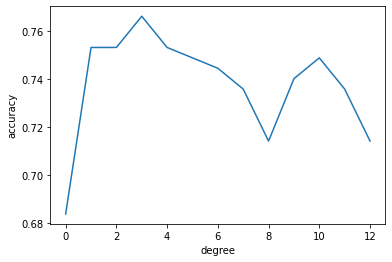

In [ ]:
#get the accuracy for a svm model with certain parameters
def accuracy_test(svm_model):
  svm_model.fit(X_train, y_train)
  y_pred = svm_model.predict(X_test)
  return accuracy_score(y_test, y_pred)
accuracies = []
#calculate the accuracies for svm with polynomial kernels of degrees 0 to 12
supdegree = 13 #maximum degree is 12
for i in range (supdegree):
  svm_model = svm.SVC(kernel="poly", degree=i)
  accuracies.append(accuracy_test(svm_model))

#now plot them
from matplotlib import pyplot as plt
degrees = list(range(supdegree))
plt.plot(degrees, accuracies)
#we can label the axes as
plt.xlabel("degree")
plt.ylabel("accuracy")
plt.show()

It seems that as we increase the degree of the model, the ability of our model to generalize on testing data decreases.

Of course, if the degree of the SVM is too small, the performance will be low as well. That is because the complexity of the model will be low, and thus it won't able to learn how to classify the data. This is called **underfitting**.

Let's check how well our model does with training data:

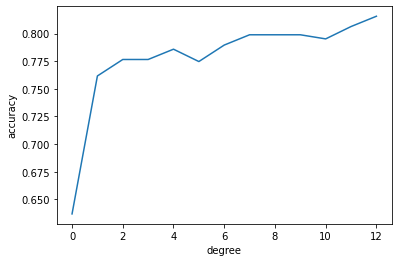

In [ ]:
#get the accuracy on training data
def accuracy_train(svm_model):
  svm_model.fit(X_train, y_train)
  y_pred = svm_model.predict(X_train)
  return accuracy_score(y_train, y_pred)

#calculate the accuracies for different degrees
supdegree = 13 #maximum degree is 12
accuracies = []
for i in range (supdegree):
  svm_model = svm.SVC(kernel="poly", degree=i)
  accuracies.append(accuracy_train(svm_model))

#now plot them
from matplotlib import pyplot as plt
degrees = list(range(supdegree))
plt.plot(degrees, accuracies)
plt.xlabel("degree")
plt.ylabel("accuracy")
plt.show()

Our model becomes better at predicting the training data as we increase the complexity, but of course, that isn't very useful, as we want to try our model on unseen data!

###Experimenting with random forests
Now let's experiment with random forests: what will happen if we increase the number of decision trees in a random forest? Will it overfit the training data?
Let's see...


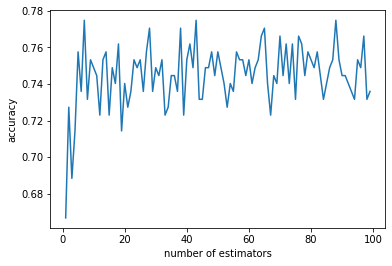

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#calculate the accuracy for a random forest
def accuracy_test(randomforest):
  randomforest.fit(X_train, y_train)
  y_pred = randomforest.predict(X_test)
  return accuracy_score(y_test, y_pred)
#calculate the accuracies for random forests with estimators from 1 to 99
accuracies = []
supestimators = 100 #maximum number of estimators is 99
for i in range (1, supestimators):
  randomforest = RandomForestClassifier(n_estimators = i)
  accuracies.append(accuracy_test(randomforest))

#now plot them
from matplotlib import pyplot as plt
n_estimators = list(range(1, supestimators))
plt.plot(n_estimators, accuracies)
plt.xlabel("number of estimators")
plt.ylabel("accuracy")
plt.show()

It turns out that as we increase the number of trees, the performance doesn't really get better, but more importantly **it doesn't get worse**. That means random forests do not tend to overfit, and that is why they are very useful for many classification tasks. Note however that it makes no sense to have random forests with many decision trees, which are computational expensive, when we can have just a few number of decision trees and get the same accuracy!

###Exercise
Play with the hyperparameters of decision trees and determine whether they are able to overfit. Can you determine what are the best hyperparameters for classification on the diabetes dataset?

##Cross-Validation
So far, we have been splitting our data into training data, with which we trained our model, and testing data, with which we tested the accuracy of our model. However this setting may be problematic: what if the partition of our data is biased?

To get a more unbiased measure of performance we can use cross-validation: **k-fold cross validation** consists of splitting the dataset into k subsets. Then, we choose one of the subsets ("folds"), train the model with the remaining k-1 folds, and finally test the trained model with the chosen fold. This is done for every fold. In practice, we usually choose k = 5 or 10.

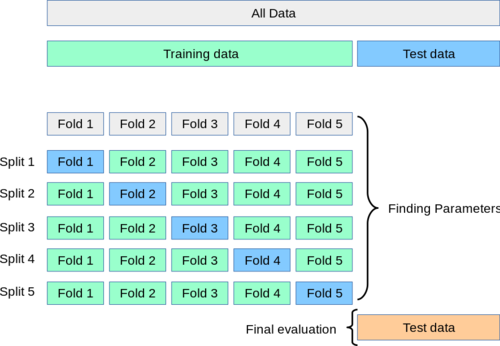

Let's have a go with sklearn.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
svm_model = svm.SVC()
#using original dataset X, y without partition into training and testing sets
scores = cross_val_score(svm.SVC(), X, y, cv = 5) #k=5
print(scores)

[0.74675325 0.73376623 0.77272727 0.79084967 0.75163399]


Depending on the partition of the dataset, we get different accuracies! We can also check the mean and standard deviation.

In [ ]:
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Mean: 0.7591460826754943
Standard deviation: 0.020217403744815586


If there was some partition of the data that makes the model perform very badly, we should look further into why our model behaved like that!

Also, if we had a **high standard deviation**, that means that we get very different accuracies depending on the partition. This may imply that we don't have **enough data**!

###Exercise
Make a manual partition of the diabetes dataset such that your model performs badly when evaluated with cross-validation (you may want to do some research on Pandas data structures).

##Choosing Optimal Hyperparameters
Now the natural question is what hyperparameters are the best for a certain model. One algorithm we can use is **grid search**, in which we divide the hyperparameter space into a grid and then try every element of that grid and check how well our model does with each combination of hyperparameters.

We can use GridSearchCV from sklearn, which allows to evaluate the model with cross-validation (CV). This prevents our model from overfitting, as we are evaluating the performance of different parameter sets on test data, so there is the possibility of choosing parameters that are optimal for that **specific** test data, and thus overfitting.

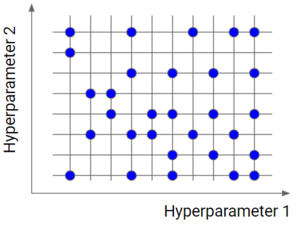

In [ ]:
from sklearn.model_selection import GridSearchCV
#try number of estimators (decision trees) from 1 to 149
grid = {"n_estimators": list(range(1, 150))}
gridsearch = GridSearchCV(RandomForestClassifier(), grid ,cv=5) #k=5
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]})

We can get the best parameters by .best_params_ :

In [ ]:
gridsearch.best_params_

{'n_estimators': 96}

And the best estimator by .best_estimator_ :

In [ ]:
best_randomforest =  gridsearch.best_estimator_

Let's check the accuracy of the best random forest:

In [ ]:
y_pred_ranforest = best_randomforest.predict(X_test)
print(accuracy_score(y_test, y_pred_ranforest))

0.7445887445887446


Note that we had to specify the grid. The broader it is, the more likely it is that our algorithm finds the optimal parameters!

###Exercise
Grid search is the most popular method to find optimal hyperparameters. However, you can also use a technique called randomized search. Look up the sklearn method RandomizedSearchCV and try to find optimal parameters with that method!

##Performance Metrics
First, we define the confusion matrix, which will help us to calculate a number of performance metrics that can help us to assess our model.

###Confusion matrix
From now on, we use the training and testing data random partition setting as it is enough for our case study.
Let $TP, FP, FN, TN$ stand for **t**rue **p**ositives, **f**alse **p**ositives, **f**alse **n**egatives, and **t**rue **n**egatives respectively. We define the confusion matrix as
$$\begin{bmatrix}
TP & FN\\
FP & TN
\end{bmatrix}$$

Let's calculate the confusion matrix with the random forest model with optimal hyperparameters that we calculated before.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_ranforest)

array([[125,  33],
       [ 26,  47]])

We can calculate a number of performance metrics with this matrix. In our case the most important one is sensivity.

###Sensivity/recall (true positive rate)
The accuracy of a model might be "innacurate".
Say that you have a model that classifies every data element as "0". Since only ~10% of the population has diabetes, our model will have an accuracy of ~90%! But of course this approach is totally wrong.

For that reason, we want to **maximize the number of true positives** with respect to the total number of positives (we want to maximize classifying diabetic patients as having diabetes). We can measure the rate of true positives with sensivity:
$$\text{sensivity} = \frac{TP}{TP+FN}.$$ This is the number of true positives divided by the total number of real positives in the dataset. We can use two methods to calculate sensivity (also called **recall**): by using the confusion matrix that we previously calculated, or with the sklearn method metrics.recall_score().

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred_ranforest)

0.6438356164383562

Note that the sensivity is considerably lower than the accuracy! Our model is not as effective as we thought...

###Exercise
There are other confusion metrics such as precision and misclassification. Look them up and try to calculate them with our confusion matrix. Are they useful in this particular case? Why would you be interested in each metric, in general?

##Model Selection
Now that we know how to calculate optimal hyperparameters for each model and how to proper evaluate the model, we need to choose a best candidate!
We compare Decision Trees, Random Forests and Support Vector Machines, with optimal hyperparameters.

In [ ]:
#calculate optimal hyperparameters for each model
#note that we already calculated optimal hyperparameters for random forests

#calculate best hyperparameters for the decision tree model
from sklearn.tree import DecisionTreeClassifier
grid = {"max_depth":list(range(1, 100))}
#scoring = "recall" as a parameter for GridSearchCV
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, cv=5)
gridsearch.fit(X_train, y_train)
best_decisiontree =  gridsearch.best_estimator_
y_pred_dectree = best_decisiontree.predict(X_test)

#calculate best hyperparameters for the svm model with polynomial kernel
grid = {"kernel": ["poly"], "degree": list(range(10))}
gridsearch = GridSearchCV(svm.SVC(), grid, cv=5)
gridsearch.fit(X_train, y_train)
best_svm =  gridsearch.best_estimator_
y_pred_svm = best_svm.predict(X_test)

Now let's see how well each model does:

In [ ]:
print("Decision tree sensivity:", recall_score(y_test, y_pred_dectree))
print("Random forest sensivity:", recall_score(y_test, y_pred_ranforest))
print("Support vector machine sensivity:", recall_score(y_test, y_pred_svm))

Decision tree sensivity: 0.4931506849315068
Random forest sensivity: 0.6438356164383562
Support vector machine sensivity: 0.4383561643835616


It seems that random forests performs the best for this particular task!
###Exercise
Evaluate the sensivity of each model (with optimal parameters) with 5-fold cross-validation. This is a more precise way to evaluate your models.
###Extensional Exercise
Study the performance of xgboost, eXtreme Gradient Boosting, (https://xgboost.readthedocs.io/) with the PIMA Indians Diabetes Dataset.

##Image Credits

https://www.iunera.com/kraken/fabric/support-vector-machines-svm/

https://www.yourdatateacher.com/2021/05/19/hyperparameter-tuning-grid-search-and-random-search/

https://scikit-learn.org/stable/modules/cross_validation.html

